# Оптимизация решения

Задание:
- оптимизировать работу выбранного решения;
- подобрать гиперпараметры;
- проанализировать итоговое качество работы модели;
- проанализировать важные признаки.

# Загрузка данных

In [4]:
import pickle
import ruclip
import zipfile
import random

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torchvision.ops import MLP
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import umap
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, silhouette_score, adjusted_mutual_info_score, v_measure_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

from tqdm.notebook import tqdm
from IPython.display import clear_output

In [5]:
tqdm.pandas()
sns.set(style='darkgrid')

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
random.seed(42)
np.random.seed(42)

In [6]:
def get_saved_ruclip_vecs(df_name, version):
    """
    Функция для загрузки сохраненных эмбеддингов, рассчитанных с помощью ruCLIP.
    """
    df = pd.read_parquet(path_to_files + f'{df_name}_preprocessed.parquet')
    
    if 'img_vec' in df.columns:
        df = df.drop(['img_vec', 'title_vec', 'desc_vec'], axis=1)
    
    latents = df[['nm']]
    
    for name, pkl in zip(['img_vec', 'title_vec', 'desc_vec'], 
                     [f'{df_name}_img_{version}.pkl', f'{df_name}_title_{version}.pkl', f'{df_name}_description_{version}.pkl']):
    
        with open(path_to_files + pkl, 'rb') as f:
            vecs = pd.DataFrame(pickle.load(f), columns=['nm', name])
            latents = latents.merge(vecs, on='nm', how='left')

    df = df.merge(latents, on='nm', how='left')
    
    return df

In [7]:
path_to_files = 'D:/HorizontalML/'
path_to_zip = path_to_files + 'wb_school_horizcv_images.zip'

train = pd.read_parquet(path_to_files + 'train_preprocessed.parquet')

In [8]:
# для логирования экспериментов
writer = SummaryWriter(log_dir=path_to_files + 'logs/')

# Baseline

В качестве базовой модели выбрана модель `ruCLIP-base`, состоящая из текстового трансформера и vision трансформера (ViT). На вход ViT подаются картинки размера 224 x 224, разделенные на патчи размера 32 x 32. Контекстное окно текстового трансформера составляет 77 токенов.

На вход текстовому энкодеру подается только заголовок товара. Изменение соотношения сторон картинок (900 x 1200) перед кодированием не проводится.

Для решения задач классификации получаемые от трансформеров эмбеддинги конкатенируются и подаются на вход многослойному перцептрону (MLP), состоящему из двух слоев размерности сконкатенированного эмбеддинга (1024). В качестве функции активации используется `ReLU`. При обучении классификатора используется оптимизатор `Adam`, `CrossEntropyLoss` - функция потерь.

In [9]:
def get_images(file_names: list) -> list[Image.Image]:
    """
    Загрузка изображений из zip-файла по списку имен файлов, преобразование из BGR(или GrayScale) в RGB,
    возврат списка всех преобразованных изображений в формате PIL Image.
    """
    images = []
    
    with zipfile.ZipFile(path_to_zip, 'r') as zf:
        for file_name in file_names:
            img = Image.open(zf.open(file_name))
            
            if img.mode == 'RGB':
            # переводим из формата BGR в RGB
                B, G, R = img.split()
                images.append(Image.merge("RGB", (R, G, B)))
                
            elif img.mode == 'L':
                # переводим из серого в RGB
                images.append(img.convert('RGB'))
                
            else:
                print('Skipping', file_name)
            
    return images

In [10]:
def expand2square(pil_img, background_color=(255, 255, 255)):
    """
    Функция для расширения изображения до квадрата.
    """
    width, height = pil_img.size
    
    if width == height:
        return pil_img
    
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [11]:
def get_image_embeddings(df, predictor, crop=False, pad=False, batch=512):
    """
    Функция для получения эмбеддингов изображений.
    """
    if crop and pad:
        raise ValueError('crop and pad cannot be True at the same time')
    
    ids = df.nm.values
    batches = [ids[i:i+batch] for i in range(0, len(ids), batch)]
    image_latents = []
    
    for batch in tqdm(batches):
        images = get_images([str(id) + '.jpg' for id in batch])
        
        if crop:
            images = [img.crop((0, 150, 900, 1050)) if img.size == (900, 1200) else img for img in images]
            
        if pad:
            images = [expand2square(img, tuple(np.array(img)[0][0])) for img in images]
        
        with torch.no_grad():
            latents = predictor.get_image_latents(images)
            
        image_latents.extend(zip(batch, latents.cpu().numpy()))
    
    clear_output()
    return image_latents

In [12]:
def get_text_embeddings(df, param, predictor, batch=512):
    """
    Функция для получения эмбеддингов текста ruCLIP.
    """
    ids = df.nm.values
    batches = [ids[i:i+batch] for i in range(0, len(ids), batch)]
    latents = []
    
    for batch in tqdm(batches):
        values = df[df.nm.isin(batch)][param].values
        if param == 'nm':
            values = get_images([str(nm) + '.jpg' for nm in batch])
        
        with torch.no_grad():
            if param == 'nm':
                batch_latents = predictor.get_image_latents(values)
            else:
                batch_latents = predictor.get_text_latents(values)
            
        latents.extend(zip(batch, batch_latents.cpu().numpy()))
        
    clear_output()
    return latents

In [13]:
class EmbedDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = torch.tensor(X)
        
        # кодируем метки
        self.le = LabelEncoder()
        self.y = self.le.fit_transform(y)
        self.y = torch.LongTensor(self.y)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [14]:
def get_dataloaders(df, X, characteristics, n_pca=None):
    """
    Функция для получения набора train и test даталоадеров для указанных характеристик/таргетов.
    """
    
    dataloaders = {}

    for char in characteristics:
        # берем только те товары, для которых указана характеристика char
        idxs = df[df[char].notna()].index

        X_char = X[idxs]
        y_char = df.loc[idxs, char].astype('str').values
        
        # разбиваем на тренировочную и тестовую выборки с учетом распределения меток
        X_train, X_test, y_train, y_test = train_test_split(X_char, y_char, test_size=0.2, random_state=42, stratify=y_char)
        
        if n_pca is not None:
            pca = PCA(n_components=n_pca)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)

        train_dataloader = DataLoader(EmbedDataset(X_train, y_train), batch_size=256, shuffle=True)
        test_dataloader = DataLoader(EmbedDataset(X_test, y_test), batch_size=256, shuffle=False)

        dataloaders[char] = {'train': train_dataloader, 'test': test_dataloader}
        
    return dataloaders

In [15]:
def eval_mlp_classifier(mlp, test_dataloader, criterion):
    """
    Функция для оценки качества модели на тестовой выборке.
    """
    mlp.eval()
    
    loss = []
    y_preds = np.array([])
    y_true = np.array([])
    
    with torch.no_grad():
        
        for X_batch, y_batch in test_dataloader:
            y_pred = mlp(X_batch)

            y_preds = np.append(y_preds, y_pred.argmax(dim=1).cpu().numpy())
            y_true = np.append(y_true, y_batch.cpu().numpy())

            loss.append(criterion(y_pred, y_batch).item())

    return np.mean(loss), f1_score(y_true, y_preds, average='macro')

In [16]:
def train_mlp_classifier(mlp, dataloaders, criterion, optimizer, model_name, param_name, epochs=12, save=False):
    """
    Функция для обучения классификатора.
    """
    history = {'train_loss': [], 'test_loss': [], 'train_f1': [], 'test_f1': []}
    
    for epoch in tqdm(range(1, epochs + 1), desc='Epochs'):
        mlp.train()
        
        epoch_train_loss = []
        y_preds = np.array([])
        y_true = np.array([])
        
        for X_batch, y_batch in dataloaders['train']:
            optimizer.zero_grad()

            y_pred = mlp(X_batch)
            loss = criterion(y_pred, y_batch)

            loss.backward()
            optimizer.step()

            epoch_train_loss.append(loss.item())
            y_preds = np.append(y_preds, y_pred.argmax(dim=1).cpu().numpy())
            y_true = np.append(y_true, y_batch.cpu().numpy())
            
        history['train_loss'].append(np.mean(epoch_train_loss))
        history['train_f1'].append(f1_score(y_true, y_preds, average='macro'))
        
        if 'test' in dataloaders:
            test_loss, f1 = eval_mlp_classifier(mlp, dataloaders['test'], criterion)

            history['test_loss'].append(test_loss)
            history['test_f1'].append(f1)
        
        # логирование обучения классификатора
        writer.add_scalars(f'{model_name}/Loss/train', {param_name: history['train_loss'][-1]}, epoch)
        writer.add_scalars(f'{model_name}/F1-macro/train',{param_name: history['train_f1'][-1]}, epoch)
        
        if 'test' in dataloaders:
            writer.add_scalars(f'{model_name}/Loss/test', {param_name: history['test_loss'][-1]}, epoch)
            writer.add_scalars(f'{model_name}/F1-macro/test', {param_name: history['test_f1'][-1]}, epoch)
    
    writer.flush()
    
    if save:
        torch.save(mlp.state_dict(), f'{path_to_files}classifiers/{model_name}_{param_name}.pt')
    
    return history

In [17]:
def plot_history(history):
    """
    Функция для отрисовки изменений значений функции потерь и метрики F1-macro в процессе обучения.
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].plot(history['train_loss'], label='train')
    ax[0].plot(history['test_loss'], label='test')
    ax[0].legend()
    ax[0].set_title('Cross Entropy Loss')
    ax[0].set_xlabel('Epoch')

    ax[1].plot(history['train_f1'], label='train')
    ax[1].plot(history['test_f1'], label='test')
    ax[1].legend()
    ax[1].set_title('F1-macro score')
    ax[1].set_xlabel('Epoch')

    plt.show()

In [18]:
def get_scores(f1_results, characteristics, dataloaders, name,
               criterion=nn.CrossEntropyLoss(),
               optimizer=torch.optim.Adam, epochs=12, save=False):

    for char in characteristics:
        dloaders = dataloaders[char]
        in_channels = dloaders['train'].dataset.X.shape[1]
        out_channels = len(dloaders['train'].dataset.le.classes_)

        mlp = MLP(in_channels=in_channels, hidden_channels=[in_channels, out_channels], dropout=0.2, activation_layer=nn.ReLU)
        optim = optimizer(mlp.parameters(), lr=1e-3)

        history = train_mlp_classifier(mlp, dloaders, criterion, optim, name, char, epochs=epochs, save=save)

        f1_results.loc[char, name] = history['test_f1'][-1]

    clear_output()
    
    return f1_results

In [19]:
# загружаем рассчитанные эмбеддинги
train = get_saved_ruclip_vecs('train', 'baseline')

In [20]:
# определяем список характеристик, по которым будет проводится классификация
characteristics = train.columns[4:-3].to_list()

# конкатенируем эмбеддинги изображения и заголовка товара
X = np.array(train[['img_vec', 'title_vec']].apply(lambda row: np.concatenate([row[0], row[1]]), axis=1).tolist())

# получаем даталоадеры для каждой характеристики
dataloaders = get_dataloaders(train, X, characteristics)

Посмотрим на изменение значения функции потерь и метрики `f1-macro` при обучении MLP классификатора. Для примера возьмем хаарктеристику "Пол".

Epochs:   0%|          | 0/12 [00:00<?, ?it/s]

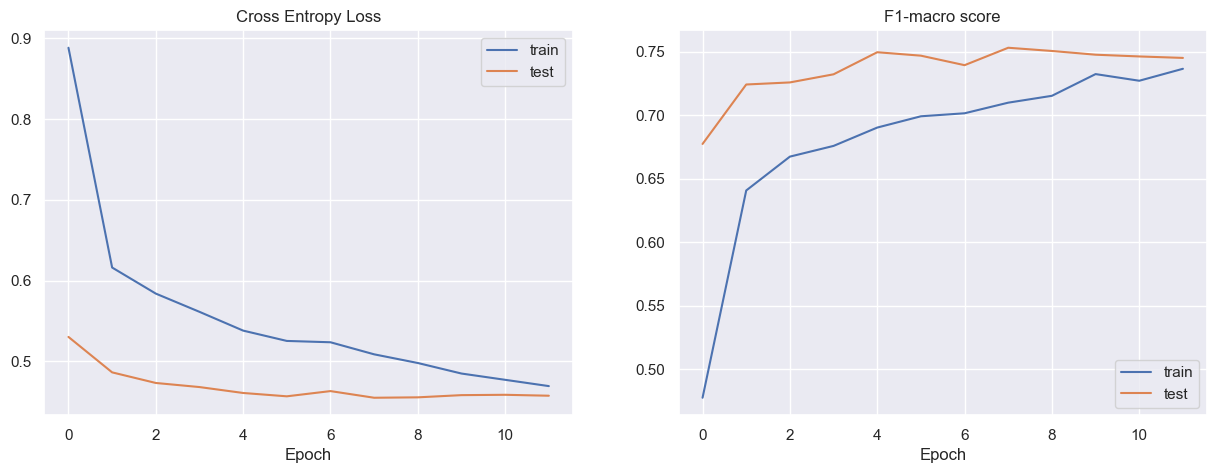

In [21]:
dloaders = dataloaders['sex']  # выбираем необходимые даталоадеры

# задаем требуемые размерности
in_channels = dloaders['train'].dataset.X.shape[1]
out_channels = len(dloaders['train'].dataset.le.classes_)

# определяем MLP классификатор, функцию потерь и оптимизатор
mlp = MLP(in_channels=in_channels, hidden_channels=[in_channels, out_channels], dropout=0.2, activation_layer=nn.ReLU)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

# обучаем и выводим результаты на графиках
history = train_mlp_classifier(mlp, dloaders, criterion, optimizer, 'baseline', 'sex')
plot_history(history)

Видно, что 12 эпох для обучения вполне достаточно.

In [22]:
# получаем результаты метрики F1-macro для всех характеристик
f1_results = pd.DataFrame({'baseline': history['test_f1'][-1]}, index=['sex'])

f1_results = get_scores(f1_results, characteristics[1:], dataloaders, 'baseline')

In [23]:
dataloaders['sex']['train'].dataset[:5][0].shape

torch.Size([5, 1024])

In [24]:
f1_results

baseline
sex               0.745052
age_restrictions  0.505439
season            0.584654
fragility         0.678144

Лучше всего товар классифицируется по характеристике "Пол", хуже всего по "Возратным ограничениям". 

# Preprocessing

Для начала попробуем немного доработать предобработку характеристик. В то время как в карточке товара продавцы указывали характеристику "Пол" только из 5 вариантов (было буквально пара ошибок, которые легко устранились), в случае остальных характеристик не было четко заданных вариантов, всё было указано в свободной форме. Их предобработка могла послужить большим источником ошибок.

Дополнительные изменения в процедуру предобработки характеристик:
- `age_restrictions`: записи с указанием 0+ удаляем из рассмотрения, поскольку там часто указывается как товар для малышей, так и для всех возрастов.
- `season`: если указываются несколько сезонностей для одного товара, то они выбираются по следующим приоритетам: лето, зима, демисезон, круглогодичный (раньше было наоборот).

In [25]:
# загружаем характеристики, полученные после предобработки по новой процедуре
chars_v1 = pd.read_csv('chars_v1.csv')
train[['sex', 'age_restrictions', 'season', 'fragility']] = chars_v1

In [26]:
dataloaders = get_dataloaders(train, X, characteristics)

f1_results = get_scores(f1_results, characteristics, dataloaders, 'baseline-v1', epochs=12)

In [27]:
f1_results

baseline  baseline-v1
sex               0.745052     0.747971
age_restrictions  0.505439     0.556139
season            0.584654     0.599173
fragility         0.678144     0.683052

Результаты для age_restrictions и season удалось улучшить

In [28]:
# в качестве baseline оставляем модель с лучшими значениями метрики F1-macro
f1_results = f1_results.drop('baseline', axis=1).rename(columns={'baseline-v1': 'baseline'})

# ruCLIP: base, patch-16, size-384

Посмотрим, как изменятся результаты, если использовать `ruCLIP-base`, в котором на вход ViT подается картинка размера 384 x 384, которая разбивается на патчи размера 16 x 16.

In [29]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# clip, processor = ruclip.load('ruclip-vit-base-patch16-384', device=device)

# predictor = ruclip.Predictor(clip, processor, device, quiet=True)

In [30]:
# img_embeddings = get_image_embeddings(test, predictor)

# with open(path_to_files + 'test_img_ruclip-p16-s384.pkl', 'wb') as f:
#     pickle.dump(img_embeddings, f)

# for col in ['title', 'description']:
#     text_embeddings = get_text_embeddings(test, col, predictor)
    
#     with open(path_to_files + f'test_{col}_ruclip-p16-s384.pkl', 'wb') as f:
#         pickle.dump(text_embeddings, f)

In [31]:
# загружаем рассчитанные эмбеддинги
train = get_saved_ruclip_vecs('train', 'ruclip-p16-s384')
train[['sex', 'age_restrictions', 'season', 'fragility']] = chars_v1

In [32]:
# конкатенируем эмбеддинги изображения и заголовка товара
X = np.array(train[['img_vec', 'title_vec']].apply(lambda row: np.concatenate([row[0], row[1]]), axis=1).tolist())

dataloaders = get_dataloaders(train, X, characteristics)

Также посмотрим процесс обучения для характеристики "Пол".

Epochs:   0%|          | 0/12 [00:00<?, ?it/s]

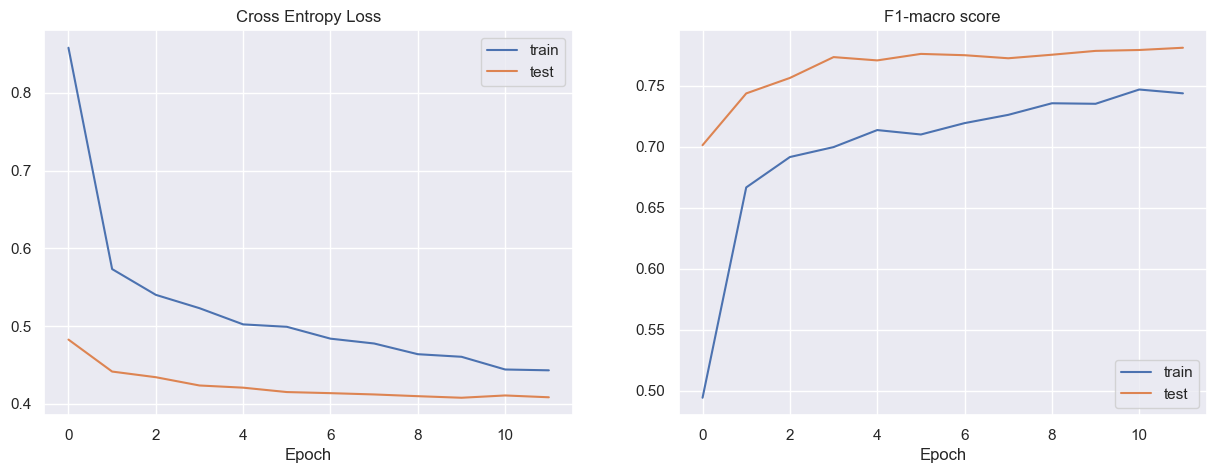

In [33]:
dloaders = dataloaders['sex']
in_channels = dloaders['train'].dataset.X.shape[1]
out_channels = len(dloaders['train'].dataset.le.classes_)

mlp = MLP(in_channels=in_channels, hidden_channels=[in_channels, out_channels], dropout=0.2, activation_layer=nn.ReLU)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

history = train_mlp_classifier(mlp, dloaders, criterion, optimizer, 'ruclip-p16-s384', 'sex', epochs=12)
plot_history(history)

In [34]:
f1_results.loc['sex', 'ruclip-p16-s384'] = history['test_f1'][-1]
f1_results = get_scores(f1_results, characteristics[1:], dataloaders, 'ruclip-p16-s384')

In [35]:
f1_results

baseline  ruclip-p16-s384
sex               0.747971         0.781088
age_restrictions  0.556139         0.544712
season            0.599173         0.617472
fragility         0.683052         0.687051

Улучшение для некоторых характеристик можно считать существенным, в то время как ухудшение метрики для остальных характеристик незначительное. В дальнейшем будем использовать эмбеддинги, полученные от модели `ruCLIP-base-patch16-s384`.

# +description, PCA

Теперь на вход MLP классификатору будем подавать сконкатеннированный вектор как эмбеддингов заголовка и изображения, так и описания. При этом перед подачей на вход MLP размерность вектора будет уменьшена с помощью `PCA`.

In [36]:
def train_early_with_pca(df, param, cols_with_vecs, model_name, n_pca=None):
    """
    Функция для обучения модели с PCA.
    """
    
    if n_pca is None:
        # задаем набор размерностей, до которых будут уменьшаться сконкатеннированные эмбеддинги
        n_pca = range(256, df[cols_with_vecs[0]].iloc[0].shape[0] * len(cols_with_vecs) + 1, 256)
    
    param_f1 = pd.DataFrame()  # для записи метрик после обучения модели с PCA
    
    # конкатенация эмбеддингов только тех товаров, для которых указана характеристика param
    X_all_param = np.array(df.loc[df[param].notna(), cols_with_vecs]\
                           .apply(lambda row: np.concatenate([row[i] for i in range(len(cols_with_vecs))]), axis=1).tolist())
    y = df.loc[train[param].notna(), param].values
    
    # разбиение датасета на train и test части
    X_train, X_test, y_train, y_test = train_test_split(X_all_param, y, test_size=0.2, random_state=42, stratify=y)
    
    for n in tqdm(n_pca):  
        # уменьшение размерности, обучение PCA только на train части
        pca = PCA(n_components=n, random_state=42)
        X_train_short = pca.fit_transform(X_train)
        X_test_short = pca.transform(X_test)
              
        dataloaders = {'train': DataLoader(EmbedDataset(X_train_short, y_train), batch_size=512, shuffle=True),
                       'test':  DataLoader(EmbedDataset(X_test_short, y_test), batch_size=512, shuffle=False)}
        
        # определение размерности слоев MLP
        in_channels = dataloaders['train'].dataset.X.shape[1]
        out_channels = len(dataloaders['train'].dataset.le.classes_)
        
        # обучение классификатора
        torch.manual_seed(42)
        mlp = MLP(in_channels=in_channels, hidden_channels=[in_channels, out_channels], dropout=0.2, activation_layer=nn.ReLU)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

        history = train_mlp_classifier(mlp, dataloaders, criterion, optimizer, model_name, f'PCA(n_components={n})', epochs=10)
        
        # сохранение полученных метрик в общую таблицу
        param_f1.loc[n, param] = history['test_f1'][-1]

    clear_output()

    return param_f1

In [37]:
# конкатенируем эмбеддинги изображения, заголовка и описания и определяем размерность, до которой лучше всего уменьшать полученный эмбеддинг
desc_f1 = train_early_with_pca(train, 'sex', ['img_vec', 'title_vec', 'desc_vec'], 'ruclip-p16-s384+desc_pca')
desc_f1.style.highlight_max(axis=0, color='lightgreen')

На основе полученных результатов обучаем классификаторы для каждой характеристики и сравниваем их метрики.

In [38]:
X_all = np.array(train[['img_vec', 'title_vec', 'desc_vec']].apply(lambda row: np.concatenate([row[0], row[1], row[2]]), axis=1).tolist())

# выбираем значение n_components исходя из полученных значений f1 (наибольшее)
dataloaders = get_dataloaders(train, X_all, characteristics, n_pca=desc_f1.idxmax()[0])

f1_results = get_scores(f1_results, characteristics, dataloaders, 'ruclip-p16-s384+desc', epochs=12)
f1_results.style.highlight_max(axis=1, color='lightgreen')

Добавление эмбеддингов описания позволяет улучшить результат.

# Late fusion

Эмбеддинги заголовка/описания/изображения товара будут подаваться на вход классификаторам (каждый по отдельности), выходы которых будут затем конкатенироваться и подаваться на вход MLP. В качестве промежуточных классификаторов будем использовать логистическую регрессию и LGBM.

In [39]:
X_all = [np.array(train[col].tolist()) for col in ['img_vec', 'title_vec', 'desc_vec']]
clfs_dict = {
    'log_reg': [LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000, random_state=42) for _ in range(3)],
    'lgbm': [LGBMClassifier(n_estimators=500, random_state=42) for _ in range(3)]
}

In [40]:
param = 'sex'
sex_f1_late = pd.DataFrame() 

idxs = train[train[param].notna()].index
idxs_train, idxs_test = train_test_split(idxs, test_size=0.2, random_state=42, stratify=train.loc[idxs, param])

for name, clfs in tqdm(clfs_dict.items()):
    X_late = None
    
    # обучение классификатора для каждого эмбеддинга по отдельности
    for i, X in enumerate(X_all):
        clfs[i].fit(X[idxs_train], train.loc[idxs_train, param])   
        if X_late is None:
            X_late = clfs[i].predict_proba(X)
        else:
            X_late = np.concatenate([X_late, clfs[i].predict_proba(X)], axis=1)
    
    # выходы трех классификаторов подаются на вход MLP
    dataloaders = get_dataloaders(train, X_late.astype(np.float32), [param])

    dloaders = dataloaders[param]
    in_channels = dloaders['train'].dataset.X.shape[1]
    out_channels = len(dloaders['train'].dataset.le.classes_)

    mlp = MLP(in_channels=in_channels, hidden_channels=[in_channels, out_channels], dropout=0.2, activation_layer=nn.ReLU)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

    history = train_mlp_classifier(mlp, dloaders, criterion, optimizer, 'late_fusion', name, epochs=12)
    
    sex_f1_late.loc[name, 'sex'] = history['test_f1'][-1]
    
clear_output()
sex_f1_late

sex
log_reg  0.806782
lgbm     0.802623

Улучшений добиться не удалось.

# Combinations

Посмотрим, какая комбинация векторов заголовка/описания/изображения дает наилучший результат классификации.

In [41]:
comb_res = pd.DataFrame()

for cols in [['img_vec'], ['title_vec'], ['desc_vec'], ['title_vec', 'desc_vec'], ['img_vec', 'desc_vec']]:
    X_all = np.array(train[cols].apply(lambda row: np.concatenate([row[i] for i in range(len(cols))]), axis=1).tolist())
    
    n_pca = desc_f1.idxmax()[0]
    if len(cols) * 512 < n_pca:
        n_pca = len(cols) * 512
    
    dataloaders = get_dataloaders(train, X_all, characteristics, n_pca=n_pca)
    
    name = '+'.join([col.split('_')[0] for col in cols])
    comb_res = get_scores(comb_res, characteristics, dataloaders, name, epochs=12)

In [42]:
comb_res = comb_res.merge(f1_results.drop('baseline', axis=1), left_index=True, right_index=True)
comb_res.columns = list(comb_res.columns[:-2]) + ['img+title', 'img+title+desc']

In [43]:
comb_res.style.background_gradient(cmap='Greens', axis=1)

# Cropped and padded images

На вход ViT подается квадратная картинка. Почти все картинки товаров имеют соотношение 3:4. Посмотрим, приведет ли к улучшению результатов crop картинок сверху и снизу (в равных пропорциях) до размера 900 x 900, или паддинг слева и справа (также в равных пропорциях) до размера 1200 x 1200. Цвет фона для паддинга выбирается на основе цвета крайнего верхнего левого пикселя картинки.

In [44]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# clip, processor = ruclip.load('ruclip-vit-base-patch16-384', device=device)
# predictor = ruclip.Predictor(clip, processor, device, quiet=True)

# img_embeddings = get_image_embeddings(train, predictor, pad=True)

# with open(path_to_files + 'train_padded_img_ruclip-p16-s384.pkl', 'wb') as f:
#     pickle.dump(img_embeddings, f)

In [45]:
for img_type in ['cropped', 'padded']:
    with open(path_to_files + f'train_{img_type}_img_ruclip-p16-s384.pkl', 'rb') as f:
        img_vecs = pd.DataFrame(pickle.load(f), columns=['nm', f'img_{img_type}_vec'])
    
    train = train.merge(img_vecs, on='nm', how='left')

In [46]:
f1_images = comb_res[['img']].copy()

for img_type in ['_cropped', '_padded']:
    X = np.array(train[f'img{img_type}_vec'].tolist())
    dataloaders = get_dataloaders(train, X, characteristics)
    
    f1_images = get_scores(f1_images, characteristics, dataloaders, f'img{img_type}', epochs=12)

In [47]:
# конкатенация всех векторов
X = np.array(train[[f'img{i}_vec' for i in ['', '_cropped', '_padded']]]\
             .apply(lambda row: np.concatenate([row[i] for i in range(3)]), axis=1).tolist())

dataloaders = get_dataloaders(train, X, characteristics, n_pca=512)
f1_images = get_scores(f1_images, characteristics, dataloaders, 'img_all_concat', epochs=12)

In [48]:
# среднее всех векторов
X = np.array(train[[f'img{i}_vec' for i in ['', '_cropped', '_padded']]]\
             .apply(lambda row: np.mean([row[i] for i in range(3)], axis=0), axis=1).tolist())

dataloaders = get_dataloaders(train, X, characteristics)
f1_images = get_scores(f1_images, characteristics, dataloaders, 'img_all_mean', epochs=12)

In [49]:
f1_images.style.background_gradient(cmap='Greens', axis=1)

Видно, что модели, обученные на эмбеддингах, полученных от изображений с кропом и паддингом, не превосходят по качеству модель, которая была обучена на основе эмбеддингов от картинок без изменений размера. Конкатенация полученных эмбеддингов от картинок с кропом, паддингом и без изменений может привести к улучшению результатов, однако они совсем незначительные.

# Splitted description

В случае описаний часть информации может теряться ввиду маленького контекстного окна текстового трансформера. Попробуем сделать следуюшее:
- разобьем текст описаний на блоки по 40 слов, причем каждый последующий блок будет захватывать 5 слов предыдущего;
- для каждого блока получаем эмбеддинги на основе текстового трансформера используемой `ruCLIP` модели;
- получаемые вектора блоков складываются и усредняются.

In [50]:
def get_text_patches(text, num_patches=4, patch_size=40, step=35):
    tokens = text.split()
    patches = []

    for i in range(num_patches):
        if i > 0 and i * step + (patch_size - step) > len(tokens):
            break
        try:
            patches.append(' '.join(tokens[i * step: i * step + patch_size]))
        except IndexError:
            break
            
    return patches

In [51]:
def get_embed_from_patches(predictor, patches):
    latents = predictor.get_text_latents(patches).detach().cpu().numpy()
    
    return np.mean(latents, axis=0)    

In [52]:
# patches = train['description'].apply(lambda x: get_text_patches(x))
# patches_latents = patches.progress_apply(lambda x: get_embed_from_patches(predictor, x))
# patches_latents = patches_latents.to_frame().rename(columns={'description': 'desc_patch_vec'})

In [53]:
patches_latents = pd.read_pickle(path_to_files + 'train_description_patches_ruclip-p16-s384.pkl')

X = np.array(patches_latents['desc_patch_vec'].tolist())

dataloaders = get_dataloaders(train, X, characteristics)
f1 = get_scores(pd.DataFrame(), characteristics, dataloaders, 'desc_patch_vec', epochs=12)

In [54]:
f1.merge(comb_res[['desc']], right_index=True, left_index=True).style.highlight_max(color='lightgreen', axis=1)

Существенных улучшений добиться не удалось.

# Clusterization

Кластеризацию будем проводить с использованием `KMeans`, а уменьшение размерности векторов с использованием `PCA` и `UMAP`.

In [55]:
def write_image(fig, tag):
    fig.canvas.draw()

    data = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (4,))[:,:,:3]
    
    writer.add_image(tag, data, 0, dataformats='HWC')

In [56]:
def plot_cluster_scores(n_clusters, scores: dict, metric='Silhouette score', show_max=False, show_label=False):
    """
    Строит график зависимости метрики качества кластеризации от количества кластеров.
    """
    
    for param, score in scores.items(): 
        max_score = max(score)
        best_n = n_clusters[score.index(max_score)]
        
        if show_max:
            sns.scatterplot(x=[best_n], y=[max_score], color='red')
            plt.text(best_n, max_score - 0.015, f'({best_n}, {max_score:.3f})')
            
        sns.lineplot(x=n_clusters, y=score, label=param if show_label else None)

    plt.xlabel('Количество кластеров')
    plt.ylabel(metric)

    plt.show();

In [57]:
def get_clusters_f1(df, characteristics):
    """
    Вычисляет метрику f1 для каждого параметра. 
    """
    f1 = {}
    
    for param in characteristics:
        cluster_to_param = df.groupby(['clusters'])[param].value_counts().groupby(level=0).head(1)

        preds = df[df[param].notna()]['clusters'].apply(lambda x: cluster_to_param[x].index[0])
        f1[param] = f1_score(preds, df.loc[df[param].notna(), param], average='macro')
        
    return f1

In [58]:
def plot_clusters(labels, reduced_xy, data='train'):
    """
    Строит график кластеризации.
    """
    df = pd.DataFrame({'x': reduced_xy[:, 0], 'y': reduced_xy[:, 1], 'label': labels})
    
    fig = plt.figure()
    for label in df.label.unique():
        plt.scatter(df[df.label == label].x, df[df.label == label].y, s=1)
    
    plt.title(f'{labels.nunique()} clusters')
    plt.show()
    
    write_image(fig, f'{data}/best_clusters')

In [59]:
def plot_clusters_by_params(df, X_reduced, characteristics, show_legend=True, data='train'):
    """
    Строит график кластеризации по параметрам.
    """
    for param in characteristics:
        cluster_to_param = df.groupby(['clusters'])[param].value_counts().groupby(level=0).head(1)

        preds = df['clusters'].apply(lambda x: cluster_to_param[x].index[0] if x in cluster_to_param else np.nan)
        idx = preds[preds.notna()].index

        df_pred = pd.DataFrame({'x': X_reduced[idx, 0], 'y': X_reduced[idx, 1], 'label': preds[idx]})


        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes = axes.flatten()

        colors = sns.color_palette('deep', n_colors=len(df_pred.label.unique()))
        uniq_labels = df_pred.label.unique()

        for i, label in enumerate(uniq_labels):
            idx = df[df[param] == label].index
            if label is not np.nan:
                axes[0].scatter(df_pred[df_pred.label == label].x, df_pred[df_pred.label == label].y, s=4, label=label, alpha=0.5, color=colors[i])
                axes[1].scatter(X_reduced[idx, 0], X_reduced[idx, 1], s=4, alpha=0.5, label=label, color=colors[i])
        
        if show_legend:
            axes[1].legend()

        idx = df[df[param].notna()].index
        f1 = f1_score(df.loc[idx, param], preds[idx], average='macro')

        fig.suptitle(f'{param} (F1-macro: {f1:.3f})')
        plt.show()
        
        write_image(fig, f'{data}/{param}')

In [60]:
def get_clusterization_metrics(df, params, clusterizer, X_reduced):
    clusterisation_results = pd.DataFrame(columns=['AMI', 'V-Measure'])

    for param in params:
        idxs = df[df[param].notna()].index
        labels = clusterizer.predict(X_reduced[idxs])

        clusterisation_results.loc[param, :] = [
            adjusted_mutual_info_score(df.loc[idxs, param], labels),
            v_measure_score(df.loc[idxs, param], labels)
        ]
        
    return clusterisation_results

In [61]:
pipeline = Pipeline([
    ('pca', PCA(n_components=512, random_state=42)), 
    ('umap', umap.UMAP(n_components=2))
])

In [62]:
concat = np.array(train[['img_vec', 'title_vec', 'desc_vec']].apply(lambda row: np.concatenate(row.values), axis=1).tolist())
X_reduced = pipeline.fit_transform(concat)

In [63]:
n_list = list(range(600, 1201, 100))
f1 = {
    'sex': [],
    'age_restrictions': [],
    'season': [],
    'fragility': []
}
silhouette = {'score': []}
chars = ['sex', 'age_restrictions', 'season', 'fragility']

for n in tqdm(n_list):
    clusterizer = KMeans(n_clusters=n, random_state=42)
    clusterizer.fit(X_reduced)
    
    train['clusters'] = clusterizer.predict(X_reduced)
    
    silhouette['score'].append(silhouette_score(X_reduced, train['clusters'], sample_size=10000))
    
    f1_ = get_clusters_f1(train, chars)
    for char in chars:
        f1[char].append(f1_[char])
        
    writer.add_scalar(f'train/silhouette', silhouette['score'][-1], n)
    writer.add_scalars(f'train/f1', {char: f1_[char] for char in chars}, n)
        
clear_output()

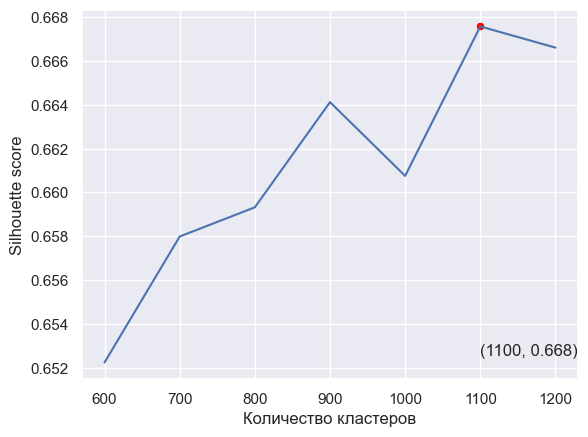

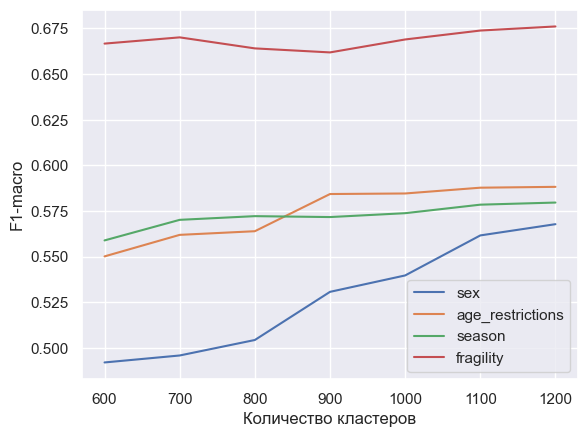

In [64]:
plot_cluster_scores(n_list, silhouette, metric='Silhouette score', show_max=True)
plot_cluster_scores(n_list, f1, metric='F1-macro', show_label=True)

In [65]:
max_score = max(silhouette['score'])
best_n = n_list[silhouette['score'].index(max_score)]

clusterizer = KMeans(n_clusters=best_n, random_state=42)
clusterizer.fit(X_reduced)

train['clusters'] = clusterizer.predict(X_reduced)

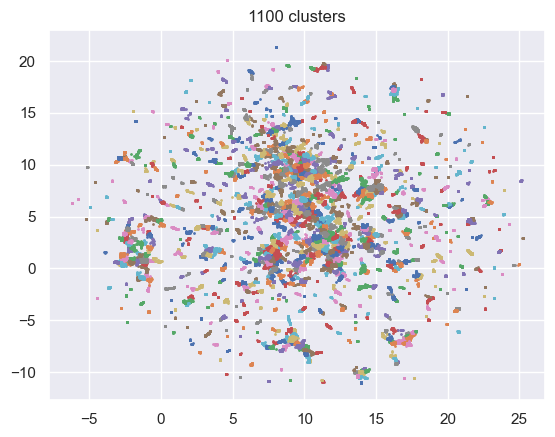

In [66]:
plot_clusters(train['clusters'], X_reduced)

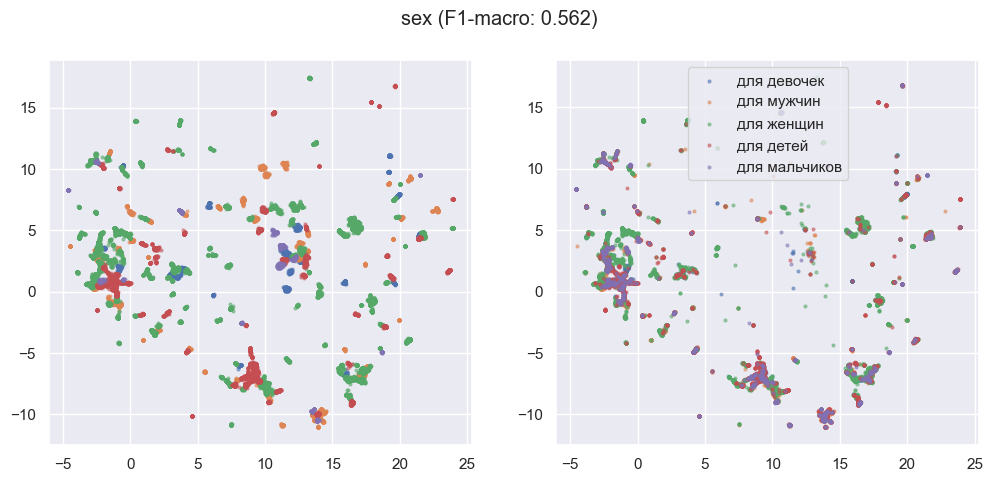

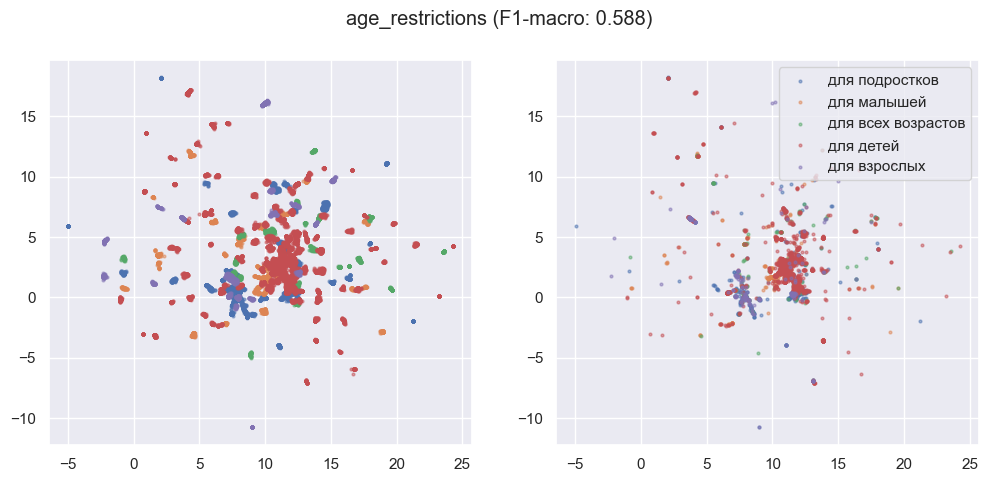

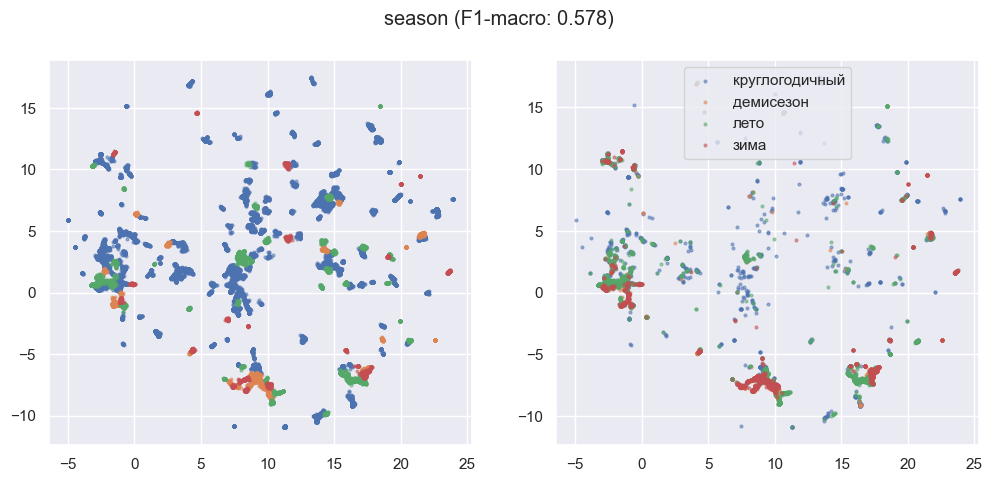

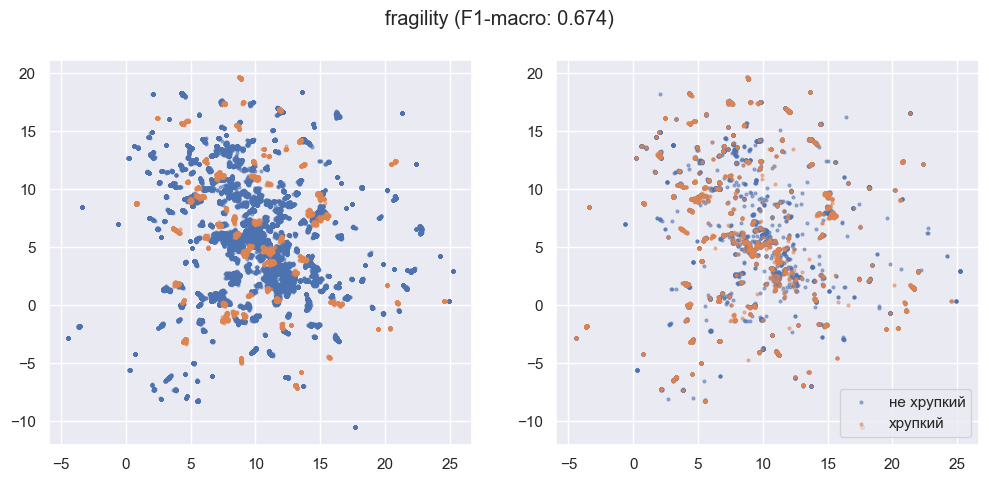

In [67]:
plot_clusters_by_params(train, X_reduced, ['sex', 'age_restrictions', 'season', 'fragility'])

In [68]:
clusterization_results = get_clusterization_metrics(train, ['sex', 'age_restrictions', 'season', 'fragility'], 
                                                    clusterizer, X_reduced)
clusterization_results

AMI V-Measure
sex                0.18905  0.195585
age_restrictions   0.18297  0.215834
season            0.129574  0.144198
fragility          0.03476  0.045619

# Test data

По результатам проведенных экспериментов лучшей моделью будем считать следующую модель:
- для получения эмбеддингов текстов и изображений используется `ruclip-p16-s384`;
- отдельно рассчитываются эмбеддинги для заголовков, описаний, изображений, которые затем конкатенируются;
- размерность сконкатенированного вектора уменьшается с использованием `PCA`;
- кластеризация проводится с использованием `KMeans`, перед которой размерность векторов уменьшается с использованием `UMAP`.

## Classification

In [69]:
test = get_saved_ruclip_vecs('test', 'ruclip-p16-s384')

In [70]:
sub_cat_freqs = test.sub_category.value_counts()
test['sub_category'] = test.sub_category.apply(lambda x: np.nan if sub_cat_freqs[x] < 10 else x)

In [71]:
test['sub_category'].nunique()

690

In [72]:
X_all = np.array(test[['img_vec', 'title_vec', 'desc_vec']].apply(lambda row: np.concatenate([row[i] for i in range(len(row))]), axis=1).tolist())
characteristics = ["sub_category", "category", "isadult"]

dataloaders = get_dataloaders(test, X_all, characteristics, n_pca=desc_f1.idxmax()[0])
test_f1 = get_scores(pd.DataFrame(), characteristics, dataloaders, 'best')

In [73]:
test_f1

best
sub_category  0.847317
category      0.879908
isadult       0.963016

## Clusterization

In [74]:
X_test_reduced = pipeline.transform(X_all)

test['clusters'] = clusterizer.predict(X_test_reduced)

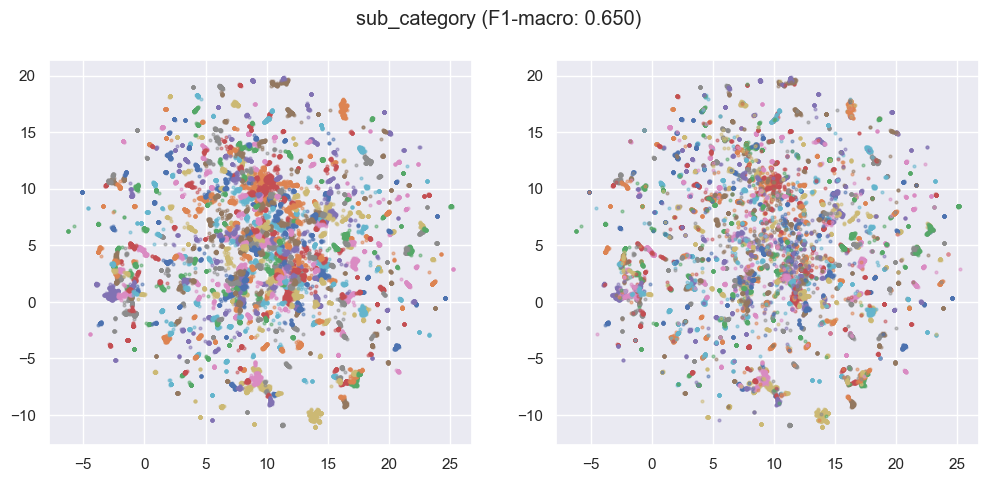

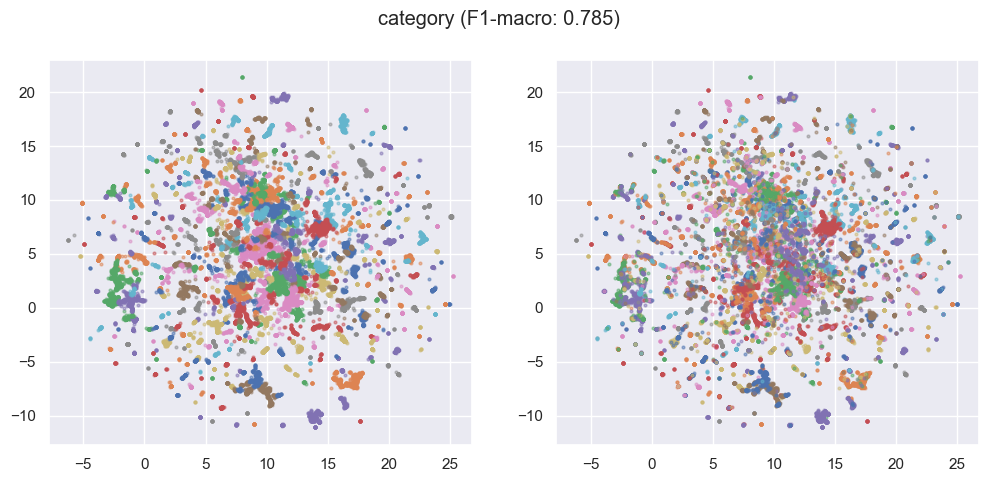

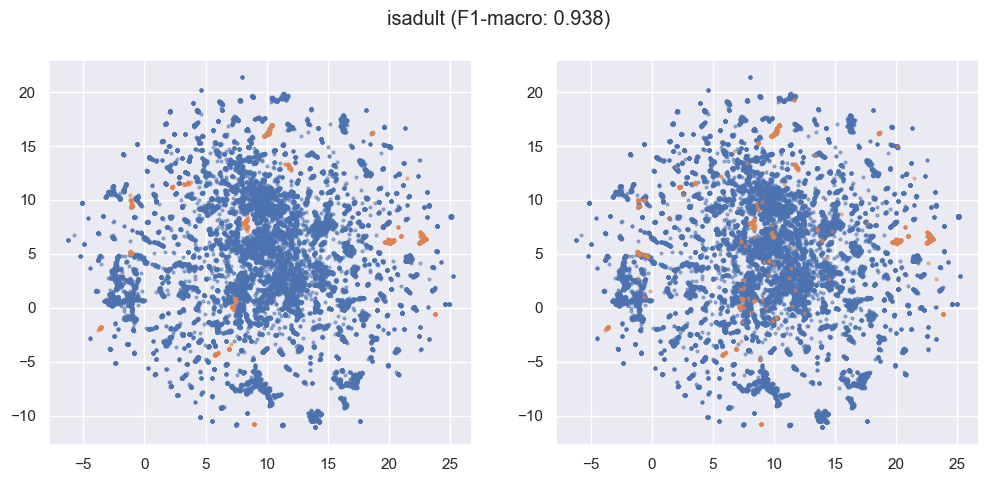

In [75]:
plot_clusters_by_params(test, X_test_reduced, characteristics, show_legend=False, data='test')

In [76]:
clusterization_results = get_clusterization_metrics(test, characteristics, clusterizer, X_test_reduced)
clusterization_results

AMI V-Measure
sub_category  0.775344  0.873292
category      0.566274  0.641466
isadult       0.028719  0.034022

In [77]:
writer.close()

## Searching similar products

In [78]:
def plot_similarities(texts: list[str], 
                      images: list[Image.Image],
                      text_latents: np.ndarray, 
                      image_latents: np.ndarray):
    """
    Функция для построения матрицы косинусного сходства эмбеддингов текста и изображений.
    """
    cos_sim = cosine_similarity(text_latents, image_latents)
    
    fig = plt.figure(figsize=(10, 9))
    sns.heatmap(cos_sim,
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm',
                yticklabels=[text[:30] + '...' if len(text) > 30 else text for text in texts], 
                xticklabels=[''] * len(texts), 
                linewidths=1, 
                cbar=False)
    plt.tick_params(bottom=False, left=False)

    ax = plt.gca()
    tick_labels = ax.xaxis.get_ticklabels()

    for i,im in enumerate(images):
        ib = OffsetImage(im, zoom=.06)
        ib.image.axes = ax
        ab = AnnotationBbox(ib,
                            tick_labels[i].get_position(),
                            frameon=False,
                            box_alignment=(0.5, 0)
                    )
        ax.add_artist(ab)

In [79]:
# выделим все дубликаты по паре заголовок-описание
all_dups = test[test.duplicated(subset=['title', 'description'], keep=False)].sort_values(by=['title', 'description'])
# пронумеруем все товары в группах дубликатов
all_dups['group_num'] = all_dups.groupby('title').title.rank(method='first')

# выделим только пары дубликатов
dup_pairs = all_dups[all_dups.group_num <= 2]

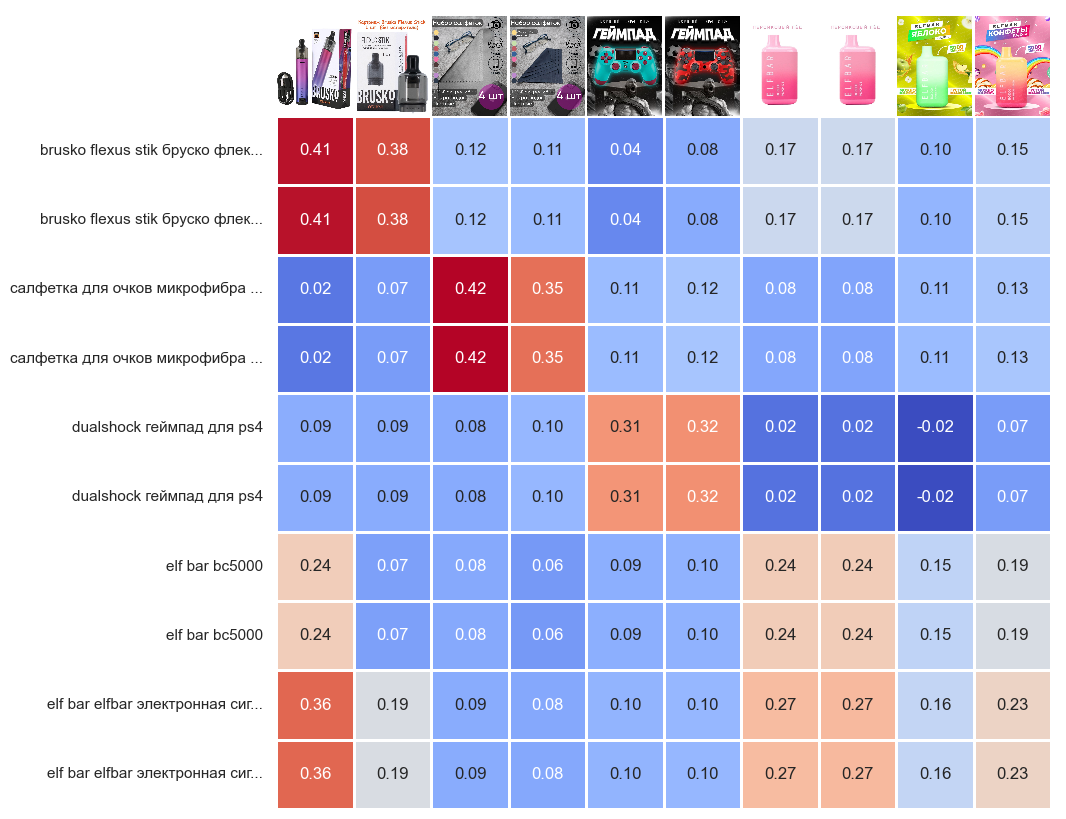

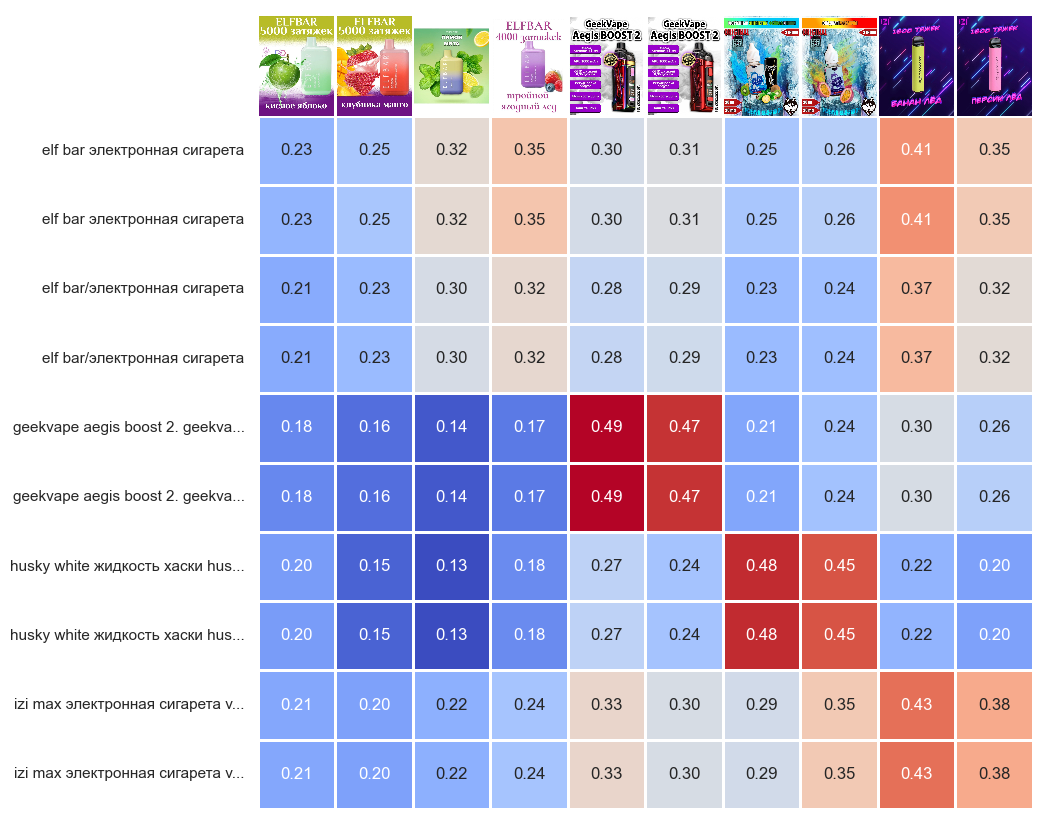

In [80]:
for i in range(2):
    s = slice(10 * i, 10 * (i + 1))
    img_names = dup_pairs.iloc[s, 0].apply(lambda x: str(x) + '.jpg').tolist()
    titles = dup_pairs.iloc[s, 1].tolist()
    text_latents = dup_pairs.iloc[s, -4].tolist()
    image_latents = dup_pairs.iloc[s, -5].tolist()

    images = get_images(img_names)

    plot_similarities(titles, images, text_latents, image_latents)

In [81]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
clip, processor = ruclip.load('ruclip-vit-base-patch16-384', device=device)
predictor = ruclip.Predictor(clip, processor, device, quiet=True)

C:\Users\Sergei\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:669: FutureWarning:

'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'

C:\Users\Sergei\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:669: FutureWarning:

'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'

C:\Users\Sergei\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:669: FutureWarning:

'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'



In [82]:
train_test = pd.concat([train[['nm', 'img_vec', 'title_vec', 'desc_vec']], test[['nm', 'img_vec', 'title_vec', 'desc_vec']]]).reset_index(drop=True)

def search_top_k(text_request, predictor, k=5, search_by='img'):
    """
    Функция для поиска товаров на основе косинусного сходства эмбеддингов запроса и заголовка/описания/изображения.
    """
    text_latent = predictor.get_text_latents([text_request]).detach().cpu().numpy()
    
    cs = cosine_similarity(text_latent, np.array(train_test[f'{search_by}_vec'].tolist())).reshape(-1)
    
    indexes = []
    vals = []
    for i in range(k):
        idx = cs.argmax()
        indexes.append(idx)
        vals.append(cs[idx])
        cs[idx] = 0
    
    images = get_images(train_test.iloc[indexes, 0].apply(lambda x: str(x) + '.jpg').tolist())
    
    fig, axes = plt.subplots(1, k, figsize=(15, 4))
    axes = axes.flatten()
    
    for i in range(k):
        axes[i].imshow(images[i])
        axes[i].axis('off')
        axes[i].set_title(f'cos_sim: {vals[i]:.2f}')
    
    fig.suptitle(f'Top {k} products for "{text_request}" (searched by {search_by})')

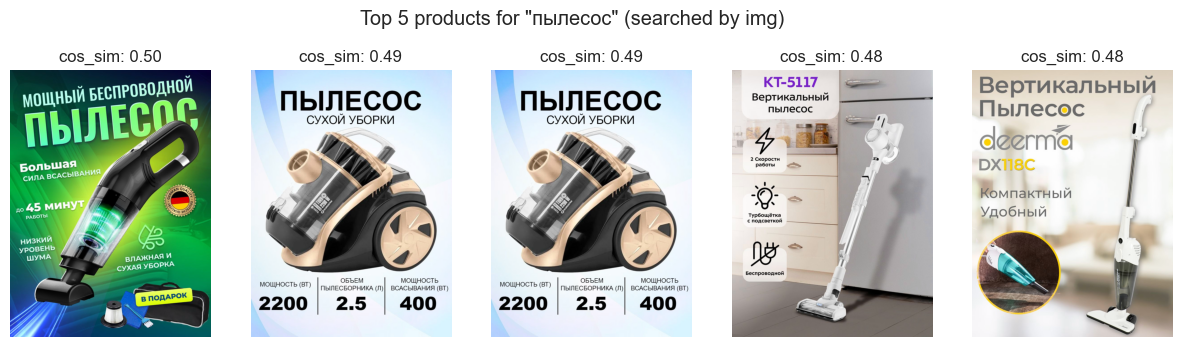

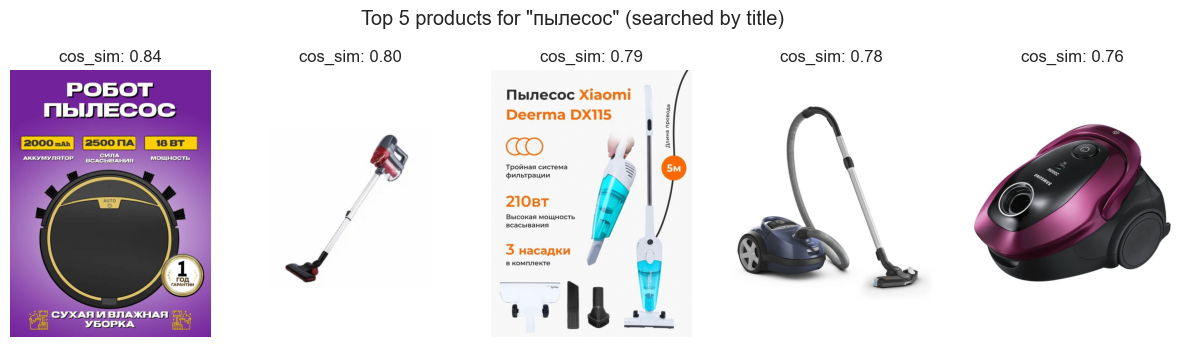

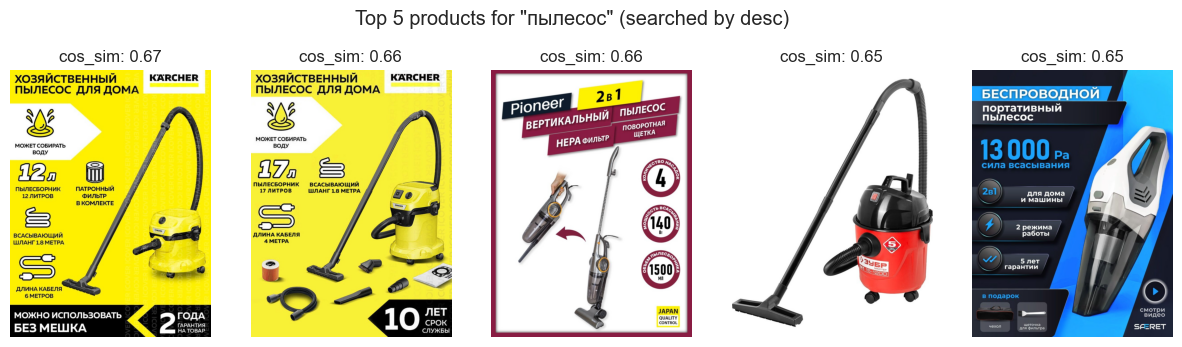

In [83]:
for search_by in ['img', 'title', 'desc']:
    search_top_k('пылесос', predictor, search_by=search_by)

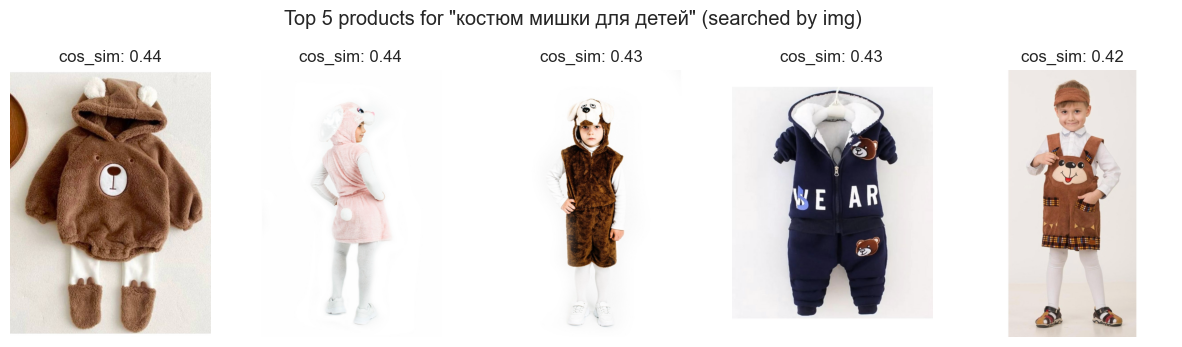

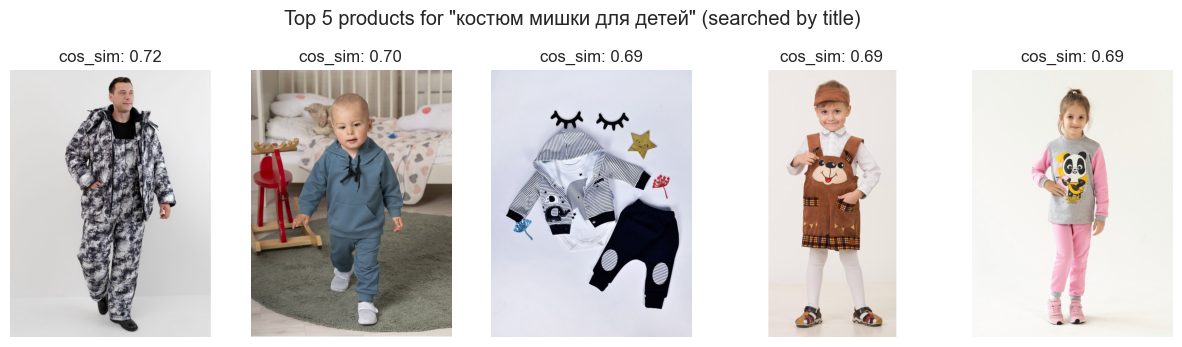

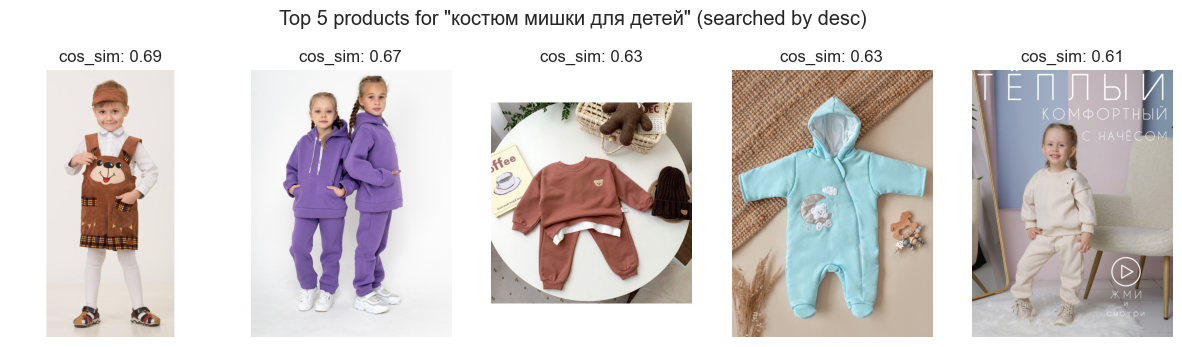

In [84]:
for search_by in ['img', 'title', 'desc']:
    search_top_k('костюм мишки для детей', predictor, search_by=search_by)

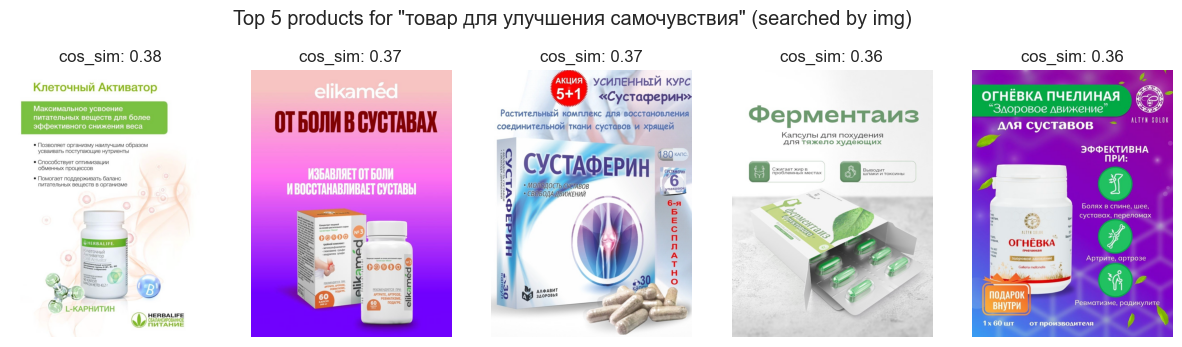

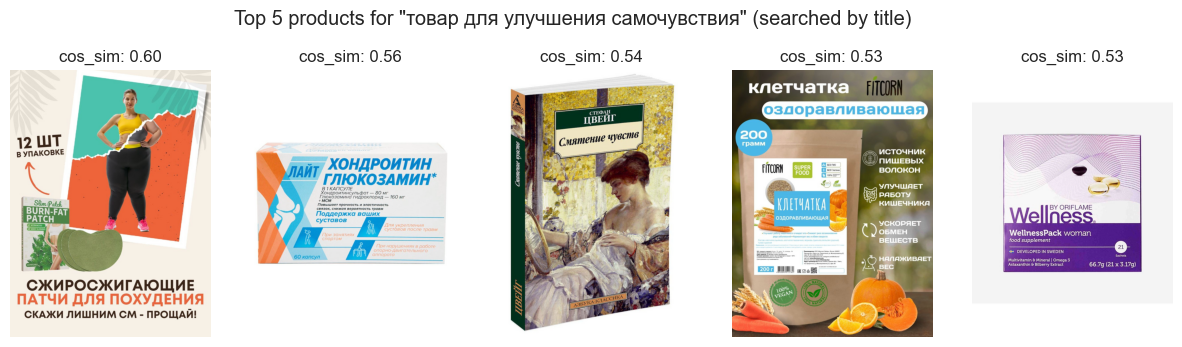

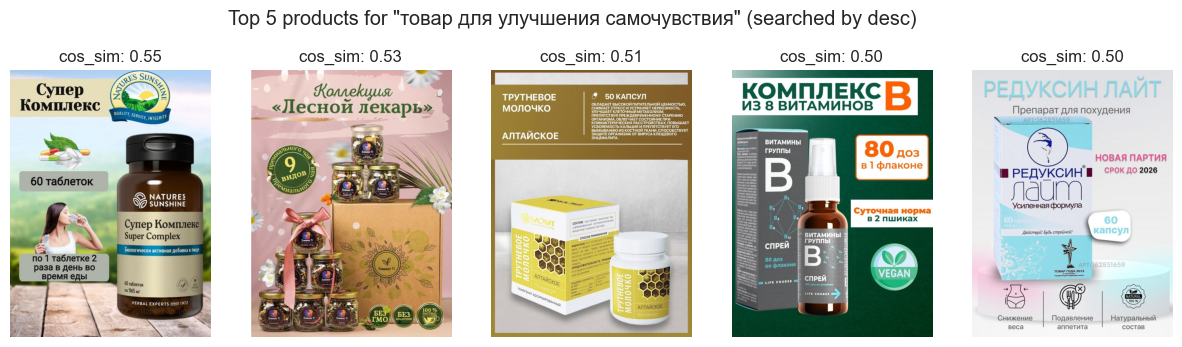

In [85]:
for search_by in ['img', 'title', 'desc']:
    search_top_k('товар для улучшения самочувствия', predictor, search_by=search_by)

# Save best classifiers

In [86]:
train_test =  pd.concat([train[['nm', 'img_vec', 'desc_vec']], test[['nm', 'img_vec', 'desc_vec']]]).reset_index(drop=True)

In [87]:
pca_all = PCA(n_components=768, random_state=42)
pca_all.fit(np.array(train_test[['img_vec', 'desc_vec']].apply(lambda row: np.concatenate([row[i] for i in range(len(row))]), axis=1).tolist()))

PCA(n_components=768, random_state=42)

In [88]:
with open(f'{path_to_files}classifiers/pca_all.pkl', 'wb') as f:
    pickle.dump(pca_all, f)

In [89]:
def get_train_dataloaders(df, X, characteristics, save_pca=True):
    dataloaders = {}

    for char in characteristics:
        # берем только те товары, для которых указана характеристика char
        idxs = df[df[char].notna()].index

        X_train = X[idxs]
        y_train = df.loc[idxs, char].astype('str').values

        X_train = pca_all.transform(X_train)

        train_dataloader = DataLoader(EmbedDataset(X_train, y_train), batch_size=256, shuffle=True)
        dataloaders[char] = {'train': train_dataloader}
        
    return dataloaders

In [90]:
X_all = np.array(train[['img_vec', 'desc_vec']].apply(lambda row: np.concatenate([row[i] for i in range(len(row))]), axis=1).tolist())
dataloaders = get_train_dataloaders(train, X_all, ['sex', 'age_restrictions', 'season', 'fragility'])

In [91]:
def train_and_save_classifiers(dataloaders, name, optimizer=torch.optim.Adam, criterion=nn.CrossEntropyLoss(), save=True):
    for char in dataloaders:
        dloaders = dataloaders[char]
        in_channels = dloaders['train'].dataset.X.shape[1]
        out_channels = len(dloaders['train'].dataset.le.classes_)

        mlp = MLP(in_channels=in_channels, hidden_channels=[in_channels, out_channels], dropout=0.2, activation_layer=nn.ReLU)
        optim = optimizer(mlp.parameters(), lr=1e-3)

        train_mlp_classifier(mlp, dloaders, criterion, optim, name, char, epochs=12, save=save)

        if save:
            torch.save(mlp, f'{path_to_files}classifiers/{name}_{char}.pt')

In [92]:
train_and_save_classifiers(dataloaders, 'mlp_train')

Epochs:   0%|          | 0/12 [00:00<?, ?it/s]

2024-05-16 21:38:11,665 - clearml.storage - INFO - Starting upload: C:\Users\Sergei\AppData\Local\Temp\.clearml.upload_model_9nfoqcwf.tmp => https://files.clear.ml/WBTECH%3A HorizontalML/Optimization of solution.b0fab8981d6144c585b720219d16615e/models/mlp_train_sex.pt
2024-05-16 21:38:16,834 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/WBTECH%253A%20HorizontalML/Optimization%20of%20solution.b0fab8981d6144c585b720219d16615e/models/mlp_train_sex.pt
2024-05-16 21:38:23,715 - clearml.storage - INFO - Starting upload: C:\Users\Sergei\AppData\Local\Temp\.clearml.upload_model_co6bzl1q.tmp => https://files.clear.ml/WBTECH%3A HorizontalML/Optimization of solution.b0fab8981d6144c585b720219d16615e/models/mlp_train_sex.pt


Epochs:   0%|          | 0/12 [00:00<?, ?it/s]

2024-05-16 21:38:27,938 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/WBTECH%253A%20HorizontalML/Optimization%20of%20solution.b0fab8981d6144c585b720219d16615e/models/mlp_train_sex.pt
2024-05-16 21:38:32,459 - clearml.storage - INFO - Starting upload: C:\Users\Sergei\AppData\Local\Temp\.clearml.upload_model_pmh2ysao.tmp => https://files.clear.ml/WBTECH%3A HorizontalML/Optimization of solution.b0fab8981d6144c585b720219d16615e/models/mlp_train_age_restrictions.pt
2024-05-16 21:38:36,660 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/WBTECH%253A%20HorizontalML/Optimization%20of%20solution.b0fab8981d6144c585b720219d16615e/models/mlp_train_age_restrictions.pt
2024-05-16 21:38:44,160 - clearml.storage - INFO - Starting upload: C:\Users\Sergei\AppData\Local\Temp\.clearml.upload_model__czygmw9.tmp => https://files.clear.ml/WBTECH%3A HorizontalML/Optimization of solution.b0fab8981d6144c585b720219d16615e/models/mlp_train_age_restrictions.pt


Epochs:   0%|          | 0/12 [00:00<?, ?it/s]

2024-05-16 21:38:48,356 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/WBTECH%253A%20HorizontalML/Optimization%20of%20solution.b0fab8981d6144c585b720219d16615e/models/mlp_train_age_restrictions.pt
2024-05-16 21:38:54,876 - clearml.storage - INFO - Starting upload: C:\Users\Sergei\AppData\Local\Temp\.clearml.upload_model_7ja5davb.tmp => https://files.clear.ml/WBTECH%3A HorizontalML/Optimization of solution.b0fab8981d6144c585b720219d16615e/models/mlp_train_season.pt
2024-05-16 21:38:59,221 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/WBTECH%253A%20HorizontalML/Optimization%20of%20solution.b0fab8981d6144c585b720219d16615e/models/mlp_train_season.pt
2024-05-16 21:39:06,767 - clearml.storage - INFO - Starting upload: C:\Users\Sergei\AppData\Local\Temp\.clearml.upload_model__cc1sqld.tmp => https://files.clear.ml/WBTECH%3A HorizontalML/Optimization of solution.b0fab8981d6144c585b720219d16615e/models/mlp_train_season.pt


Epochs:   0%|          | 0/12 [00:00<?, ?it/s]

2024-05-16 21:39:11,204 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/WBTECH%253A%20HorizontalML/Optimization%20of%20solution.b0fab8981d6144c585b720219d16615e/models/mlp_train_season.pt
2024-05-16 21:39:16,803 - clearml.storage - INFO - Starting upload: C:\Users\Sergei\AppData\Local\Temp\.clearml.upload_model_o0h5zbxx.tmp => https://files.clear.ml/WBTECH%3A HorizontalML/Optimization of solution.b0fab8981d6144c585b720219d16615e/models/mlp_train_fragility.pt
2024-05-16 21:39:20,998 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/WBTECH%253A%20HorizontalML/Optimization%20of%20solution.b0fab8981d6144c585b720219d16615e/models/mlp_train_fragility.pt
2024-05-16 21:39:28,647 - clearml.storage - INFO - Starting upload: C:\Users\Sergei\AppData\Local\Temp\.clearml.upload_model_jrmnkqdv.tmp => https://files.clear.ml/WBTECH%3A HorizontalML/Optimization of solution.b0fab8981d6144c585b720219d16615e/models/mlp_train_fragility.pt


In [93]:
X_all = np.array(test[['img_vec', 'desc_vec']].apply(lambda row: np.concatenate([row[i] for i in range(len(row))]), axis=1).tolist())
dataloaders = get_train_dataloaders(test, X_all, ['category', 'sub_category', 'isadult'])
train_and_save_classifiers(dataloaders, 'mlp_test')

Epochs:   0%|          | 0/12 [00:00<?, ?it/s]

2024-05-16 21:39:32,985 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/WBTECH%253A%20HorizontalML/Optimization%20of%20solution.b0fab8981d6144c585b720219d16615e/models/mlp_train_fragility.pt
2024-05-16 21:39:53,001 - clearml.storage - INFO - Starting upload: C:\Users\Sergei\AppData\Local\Temp\.clearml.upload_model_4_pvrid1.tmp => https://files.clear.ml/WBTECH%3A HorizontalML/Optimization of solution.b0fab8981d6144c585b720219d16615e/models/mlp_test_category.pt
2024-05-16 21:39:57,530 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/WBTECH%253A%20HorizontalML/Optimization%20of%20solution.b0fab8981d6144c585b720219d16615e/models/mlp_test_category.pt
2024-05-16 21:40:05,042 - clearml.storage - INFO - Starting upload: C:\Users\Sergei\AppData\Local\Temp\.clearml.upload_model_v2zyfx2p.tmp => https://files.clear.ml/WBTECH%3A HorizontalML/Optimization of solution.b0fab8981d6144c585b720219d16615e/models/mlp_test_category.pt


Epochs:   0%|          | 0/12 [00:00<?, ?it/s]

2024-05-16 21:40:09,582 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/WBTECH%253A%20HorizontalML/Optimization%20of%20solution.b0fab8981d6144c585b720219d16615e/models/mlp_test_category.pt
2024-05-16 21:40:26,641 - clearml.storage - INFO - Starting upload: C:\Users\Sergei\AppData\Local\Temp\.clearml.upload_model_uooj64dv.tmp => https://files.clear.ml/WBTECH%3A HorizontalML/Optimization of solution.b0fab8981d6144c585b720219d16615e/models/mlp_test_sub_category.pt
2024-05-16 21:40:34,527 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/WBTECH%253A%20HorizontalML/Optimization%20of%20solution.b0fab8981d6144c585b720219d16615e/models/mlp_test_sub_category.pt
2024-05-16 21:40:38,814 - clearml.storage - INFO - Starting upload: C:\Users\Sergei\AppData\Local\Temp\.clearml.upload_model_sgif9fos.tmp => https://files.clear.ml/WBTECH%3A HorizontalML/Optimization of solution.b0fab8981d6144c585b720219d16615e/models/mlp_test_sub_category.pt


Epochs:   0%|          | 0/12 [00:00<?, ?it/s]

2024-05-16 21:40:46,755 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/WBTECH%253A%20HorizontalML/Optimization%20of%20solution.b0fab8981d6144c585b720219d16615e/models/mlp_test_sub_category.pt
2024-05-16 21:40:57,580 - clearml.storage - INFO - Starting upload: C:\Users\Sergei\AppData\Local\Temp\.clearml.upload_model_6ul121x2.tmp => https://files.clear.ml/WBTECH%3A HorizontalML/Optimization of solution.b0fab8981d6144c585b720219d16615e/models/mlp_test_isadult.pt
2024-05-16 21:41:01,768 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/WBTECH%253A%20HorizontalML/Optimization%20of%20solution.b0fab8981d6144c585b720219d16615e/models/mlp_test_isadult.pt
2024-05-16 21:41:09,286 - clearml.storage - INFO - Starting upload: C:\Users\Sergei\AppData\Local\Temp\.clearml.upload_model_bm0aipjx.tmp => https://files.clear.ml/WBTECH%3A HorizontalML/Optimization of solution.b0fab8981d6144c585b720219d16615e/models/mlp_test_isadult.pt
2024-05-16 21:41:15,075 -